In [2]:
import torch
from pathlib import Path
from dataset import GraspDataset

# Create dataset
data_path = Path('data/processed')
dataset = GraspDataset(data_path)

# Get a single sample
sample = dataset[0]

# Print available keys
print("Sample contains the following keys:")
for key in sample.keys():
    print(f"- {key}")

# Print tensor shapes and data types
print("\nTensor shapes and types:")
for key, tensor in sample.items():
    print(f"{key}:")
    print(f"  Shape: {tensor.shape}")
    print(f"  Type: {tensor.dtype}")
    print(f"  Device: {tensor.device}")
    if tensor.numel() < 10:  # Only print full tensor if it's small
        print(f"  Values: {tensor}")
    print()

# Basic statistics for numerical tensors
print("\nBasic statistics:")
for key, tensor in sample.items():
    if torch.is_floating_point(tensor):
        print(f"{key}:")
        print(f"  Min: {tensor.min().item():.4f}")
        print(f"  Max: {tensor.max().item():.4f}")
        print(f"  Mean: {tensor.mean().item():.4f}")
        print(f"  Std: {tensor.std().item():.4f}")
        print()


Sample contains the following keys:
- sdf
- grasps
- scores

Tensor shapes and types:
sdf:
  Shape: torch.Size([48, 48, 48])
  Type: torch.float32
  Device: cpu

grasps:
  Shape: torch.Size([480, 7])
  Type: torch.float64
  Device: cpu

scores:
  Shape: torch.Size([480])
  Type: torch.float64
  Device: cpu


Basic statistics:
sdf:
  Min: -0.7169
  Max: 1.4683
  Mean: 0.6416
  Std: 0.2782

grasps:
  Min: -0.5236
  Max: 1.8326
  Mean: 0.1521
  Std: 0.4945

scores:
  Min: -1.5000
  Max: 8.6819
  Mean: 1.6106
  Std: 2.8319



Using device: cpu
Using a subset of 10 samples for this test run.
Subset samples: 10, Calculated train size: 8, Calculated val size: 2
Final split for random_split: train_size=8, val_size=2
Actual training set size: 8
Actual validation set size: 2

Starting quick training for 10 epochs...


Epoch [1/10], Train Loss: 53.0568, Val Loss: 153.9784


Epoch [2/10], Train Loss: 79.7928, Val Loss: 145.2111


Epoch [3/10], Train Loss: 61.6186, Val Loss: 148.4933


Epoch [4/10], Train Loss: 57.6014, Val Loss: 126.0907


Epoch [5/10], Train Loss: 51.0146, Val Loss: 83.6968


Epoch [6/10], Train Loss: 60.8931, Val Loss: 140.3089


Epoch [7/10], Train Loss: 55.0230, Val Loss: 124.9726


Epoch [8/10], Train Loss: 39.1324, Val Loss: 81.9589


Epoch [9/10], Train Loss: 57.6932, Val Loss: 125.8515


Epoch [10/10], Train Loss: 46.1521, Val Loss: 109.8738


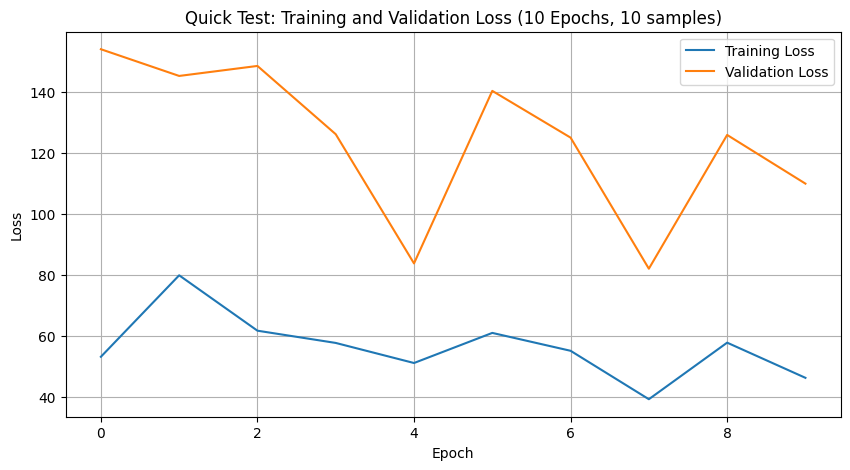

In [6]:
import torch
from pathlib import Path
from dataset import GraspDataset
from torch.utils.data import DataLoader, random_split, Subset
from model import GQEstimator
import matplotlib.pyplot as plt
from tqdm import tqdm
import math

# --- Parameters for Quick Test ---
NUM_TOTAL_SAMPLES_TO_USE = 10  # Use only 5 samples in total from the dataset
NUM_EPOCHS_QUICK_TEST = 10     # Run for only 3 epochs
# --- End Parameters for Quick Test ---

# Initialize model and move to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = GQEstimator().to(device)

# Create dataset
data_path = Path('data/processed')
try:
    full_dataset_obj = GraspDataset(data_path) # Load the full dataset object first
    
    # --- Use a subset for quick testing ---
    if len(full_dataset_obj) < NUM_TOTAL_SAMPLES_TO_USE:
        print(f"Warning: Full dataset has {len(full_dataset_obj)} samples, which is less than NUM_TOTAL_SAMPLES_TO_USE ({NUM_TOTAL_SAMPLES_TO_USE}). Using all available samples.")
        subset_indices = list(range(len(full_dataset_obj)))
    else:
        subset_indices = list(range(NUM_TOTAL_SAMPLES_TO_USE))
    
    active_dataset = Subset(full_dataset_obj, subset_indices)
    print(f"Using a subset of {len(active_dataset)} samples for this test run.")
    # --- End subset usage ---

except Exception as e:
    print(f"Error loading dataset from {data_path}: {e}")
    raise

# Split dataset into training and validation
val_split = 0.2
num_samples = len(active_dataset) # Now using the length of the subset

train_size = int(num_samples * (1 - val_split))
val_size = num_samples - train_size

print(f"Subset samples: {num_samples}, Calculated train size: {train_size}, Calculated val size: {val_size}")

batch_size = 1

train_dataset, val_dataset = random_split(active_dataset, [train_size, val_size], generator=torch.Generator().manual_seed(42))

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True if device.type != 'cpu' else False) # num_workers=0 for small N
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True if device.type != 'cpu' else False)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.MSELoss()
# Use NUM_EPOCHS_QUICK_TEST
num_epochs = NUM_EPOCHS_QUICK_TEST 
train_losses = []
val_losses = []

print(f"\nStarting quick training for {num_epochs} epochs...")
for epoch in range(num_epochs):
    model.train()
    epoch_train_loss = 0.0
    num_train_batches_processed = 0

    for batch_data in tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs} Training", leave=False):
        # ... (rest of your training loop logic for a batch) ...
        sdf = batch_data['sdf'].float().to(device)
        hand_pose_batch = batch_data['grasps'].float().to(device)
        scores_batch = batch_data['scores'].float().to(device)

        num_grasps_in_sample = hand_pose_batch.shape[1]
        if num_grasps_in_sample == 0: continue

        batch_sample_train_loss = 0.0
        optimizer.zero_grad()
        for i in range(num_grasps_in_sample): # Consider limiting i for extreme speed up, e.g. range(min(num_grasps_in_sample, 5))
            current_hand_pose = hand_pose_batch[:, i, :]
            current_score = scores_batch[:, i].unsqueeze(1)
            sdf_with_channel = sdf.unsqueeze(1)
            
            pred_quality = model(sdf_with_channel, current_hand_pose)
            loss = criterion(pred_quality, current_score)
            loss.backward()
            batch_sample_train_loss += loss.item()
        
        optimizer.step()
        epoch_train_loss += (batch_sample_train_loss / num_grasps_in_sample)
        num_train_batches_processed +=1

    if num_train_batches_processed > 0:
        avg_epoch_train_loss = epoch_train_loss / num_train_batches_processed
    else: 
        avg_epoch_train_loss = float('nan')
    train_losses.append(avg_epoch_train_loss)

    avg_epoch_val_loss = float('nan')
    if val_dataloader:
        model.eval()
        epoch_val_loss = 0.0
        num_val_batches_processed = 0
        with torch.no_grad():
            for batch_data in tqdm(val_dataloader, desc=f"Epoch {epoch+1}/{num_epochs} Validation", leave=False):
                # ... (rest of your validation loop logic for a batch) ...
                sdf = batch_data['sdf'].float().to(device)
                hand_pose_batch = batch_data['grasps'].float().to(device)
                scores_batch = batch_data['scores'].float().to(device)

                num_grasps_in_sample = hand_pose_batch.shape[1]
                if num_grasps_in_sample == 0: continue

                batch_sample_val_loss = 0.0
                for i in range(num_grasps_in_sample): # Consider limiting i
                    current_hand_pose = hand_pose_batch[:, i, :]
                    current_score = scores_batch[:, i].unsqueeze(1)
                    sdf_with_channel = sdf.unsqueeze(1)
                    
                    pred_quality = model(sdf_with_channel, current_hand_pose)
                    loss_val = criterion(pred_quality, current_score)
                    batch_sample_val_loss += loss_val.item()
                
                epoch_val_loss += (batch_sample_val_loss / num_grasps_in_sample)
                num_val_batches_processed +=1
        
        if num_val_batches_processed > 0:
            avg_epoch_val_loss = epoch_val_loss / num_val_batches_processed
        val_losses.append(avg_epoch_val_loss)
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_epoch_train_loss:.4f}, Val Loss: {avg_epoch_val_loss:.4f}')
    else:
        val_losses.append(avg_epoch_val_loss)
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_epoch_train_loss:.4f} (No validation set)')

# Plot loss curve
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plot_val_epochs = [i for i, vl in enumerate(val_losses) if not (isinstance(vl, float) and math.isnan(vl))]
plot_val_losses_values = [vl for vl in val_losses if not (isinstance(vl, float) and math.isnan(vl))]
if plot_val_losses_values:
   plt.plot(plot_val_epochs, plot_val_losses_values, label='Validation Loss')
plt.title(f'Quick Test: Training and Validation Loss ({NUM_EPOCHS_QUICK_TEST} Epochs, {len(active_dataset)} samples)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()
